In [1]:
!pip install scikit-learn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mnist
import sklearn.metrics
import sklearn.model_selection

In [3]:
ROWS                  = 5
COLUMNS               = 5
NEIGHBOURS            = 30
DIMENSIONS            = 64
NUMBER_OF_IMAGES_PCA  = 2000
NUMBER_OF_IMAGES_KNN  = 400
STEP                  = 1

In [4]:
class my_PCA():

    def __init__(self, n_components = None):
        if not isinstance(n_components, int):
            raise TypeError("Переданный параметр n_components должен быть целочисленным")
        if n_components <= 0:
            raise ValueError("Число размерностей подпространства n_components не может быть неположительным")

        self.__n_components = n_components

    def display_input_data(self, train, validation, test):
        print("Число картинок: ", len(train[0]))
        print("Сами числа в виде Numpy-массива", train[1])
        print("Число картинок, поделащих валидации:", len(validation[0]))
        print("Картинки, подлежащие валидации, в виде Numpy-массива:", validation[1])

    def display_some_MNIST_digits(self, images, rows = ROWS, columns = COLUMNS, title = "Image №", suptitle = "MNIST Images"):
        plt.figure(figsize = (10, 10))
        for index in range(1, rows * columns + 1):
            plt.subplot(rows, columns, index)
            plt.imshow(images[index - 1], cmap = plt.get_cmap("gray"))
            plt.xticks([])
            plt.yticks([])
            plt.title(title + str(index))
        plt.suptitle(suptitle)
        plt.show()

    def fit_transform(self, X):
        # Центрирование
        mean_vector = np.mean(X, axis = 0)
        self.__X_centered = X - mean_vector

        # SVD-разложение
        U, S, V_T = np.linalg.svd(self.__X_centered.transpose() @ self.__X_centered, full_matrices = False)

        F = V_T.transpose()
        self.__eigenvectors = np.zeros((F.shape[0], F.shape[1]))
        for i in range(0, F.shape[0], 1):
            self.__eigenvectors[i] = F[ : , i]

        S = np.diag(S)
        Lambda_matrix = S.transpose() @ S
        self.__eigenvalues = np.zeros((F.shape[0]))
        for i in range(0, Lambda_matrix.shape[0], 1):
            self.__eigenvalues[i] = Lambda_matrix[i, i]

        sorted_indexes               = np.argsort(self.__eigenvalues)[ : : -1]
        self.__sorted_eigenvalues    = self.__eigenvalues[sorted_indexes]
        self.__sorted_eigenvectors   = self.__eigenvectors[ : , sorted_indexes]

        return self.__X_centered @ F[ : , : self.__n_components]

    def get_eigenvalues_ratio(self):
        return self.__sorted_eigenvalues[ : self.__n_components] / np.sum(self.__sorted_eigenvalues[ : self.__n_components])

    def get_cum_ratio(self):
        return np.cumsum(self.get_eigenvalues_ratio())

In [5]:
#    train - кортеж, 1-ый элемент которого - это изображения размером 28 x 28 пикселей, каждому из которых поставлена в соответствие матрциа 28 x 28
#                    2-ой элемент которого - это сами цифры в обычном числовом формате, закодированные соответствующими изображениями.

train, validation, test = mnist.load_mnist()

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


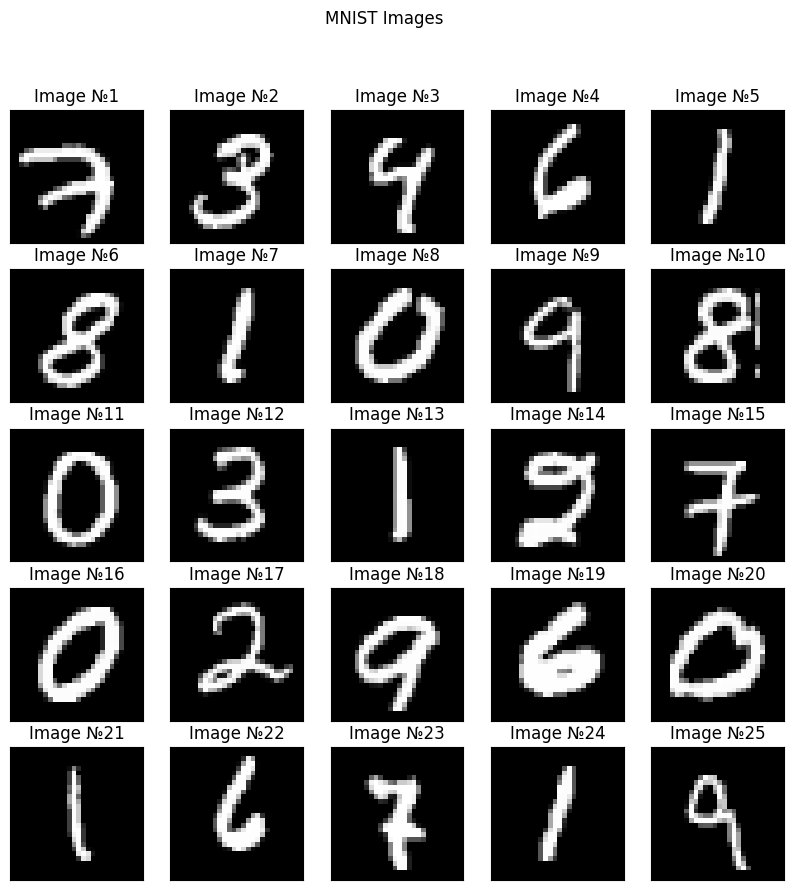

In [6]:
my_pca = my_PCA(DIMENSIONS)
my_pca.display_some_MNIST_digits(train[0])

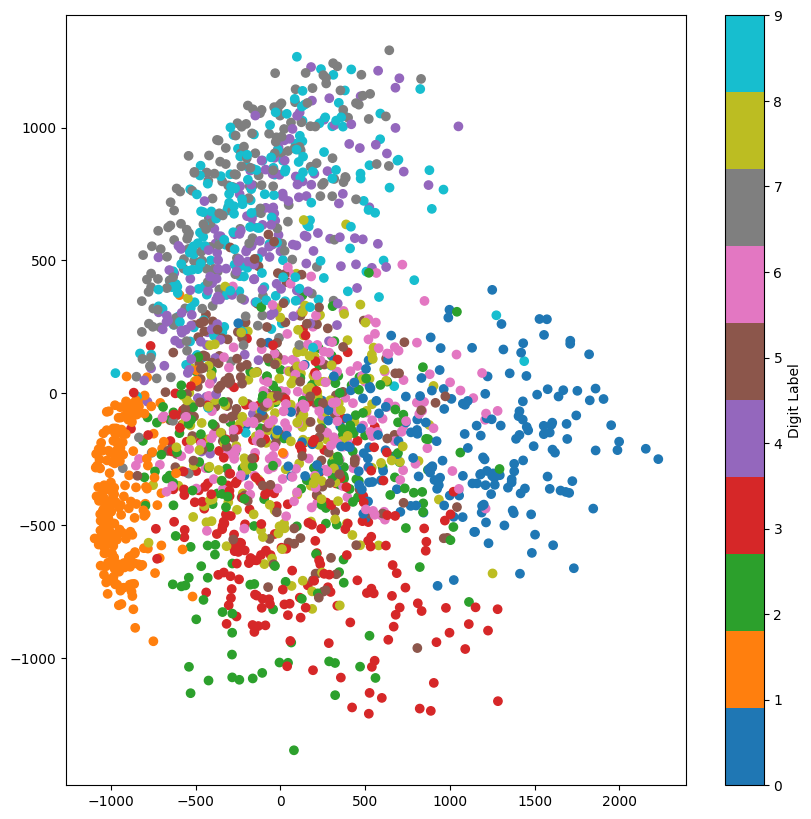

In [7]:
train_images = train[0].reshape(train[0].shape[0], -1).astype("float64")
train_labels = train[1].reshape(train[1].shape[0]).astype("uint8")
Y = my_pca.fit_transform(train_images[ : NUMBER_OF_IMAGES_PCA])

plt.figure(figsize = (10, 10))
scatter = plt.scatter(Y[ : , 0], Y[ : , 1], c = train_labels[ : NUMBER_OF_IMAGES_PCA], cmap = "tab10")
plt.colorbar(scatter, ticks = range(10), label = "Digit Label")
plt.show()

In [8]:
font1 = {"family" : "serif", "color": "darkred", "size": 20}
font2 = {"family" : "serif", "color": "navy", "size": 25}

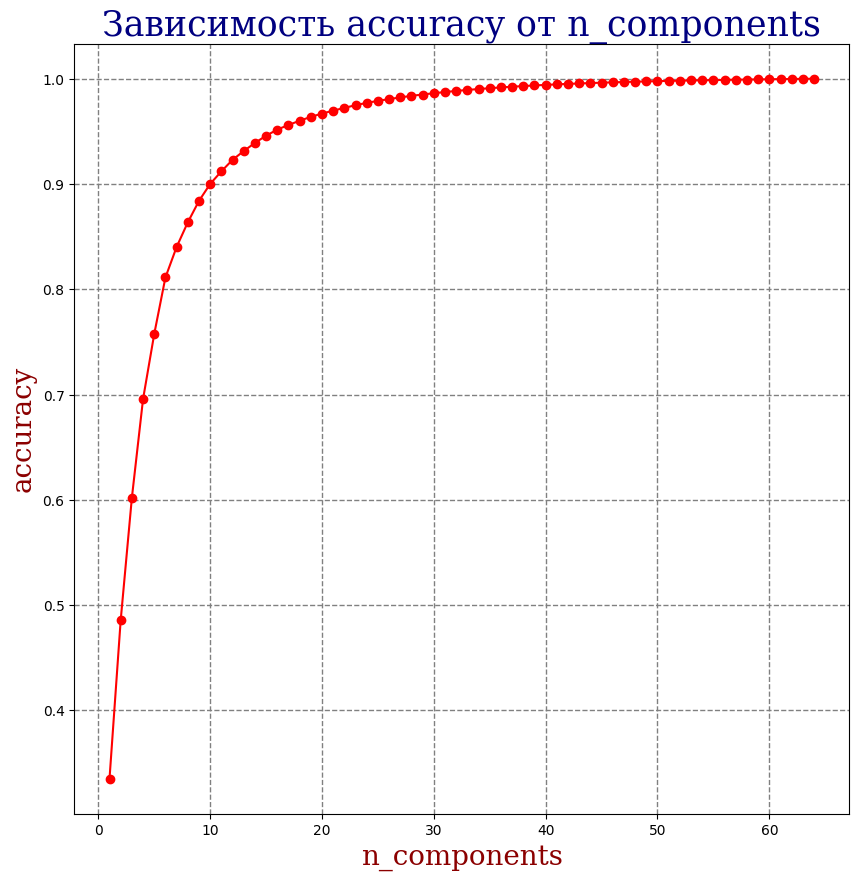

In [9]:
eigenvalues_ratio = my_pca.get_eigenvalues_ratio()
cum_ratio = my_pca.get_cum_ratio()
plt.figure(figsize = (10, 10))
plt.plot(range(1, len(eigenvalues_ratio) + 1), cum_ratio, marker = "o", color = "red")
plt.xlabel("n_components", fontdict = font1)
plt.ylabel("accuracy", fontdict = font1)
plt.title("Зависимость accuracy от n_components", fontdict = font2)
plt.grid(color = "gray", linestyle = "--", linewidth = 1.0)
plt.show()

In [33]:
class my_KNN():

    def __init__(self, n_neighbours):
        if not isinstance(n_neighbours, int):
            raise TypeError("Переданный параметр n_neighbours должен быть целочисленным")
        if n_neighbours <= 0:
            raise ValueError("Переданный параметр n_neighbours не может быть неположительным")

        self.n_neighbours = n_neighbours

    def set_number_of_neighbours(self, neighbours):
        if not isinstance(neighbours, int):
            raise TypeError("Переданный параметр neighbours должен быть целочисленным")
        if neighbours <= 0:
            raise ValueError("Переданный параметр neighbours не может быть неположительным")

        self.n_neighbours = neighbours

    def display_input_data(self, train, validation, test):
        print("Число картинок: ", len(train[0]))
        print("Сами числа в виде Numpy-массива", train[1])
        print("Число картинок, поделащих валидации:", len(validation[0]))
        print("Картинки, подлежащие валидации, в виде Numpy-массива:", validation[1])

    def display_MNIST_digits(self, images, rows = ROWS, columns = COLUMNS, title = "Image №", suptitle = "MNIST Images"):
        plt.figure(figsize = (10, 10))
        for index in range(1, rows * columns + 1):
            plt.subplot(rows, columns, index)
            plt.imshow(images[index - 1], cmap = plt.get_cmap("gray"))
            plt.xticks([])
            plt.yticks([])
            plt.title(title + str(index))
        plt.suptitle(suptitle)
        plt.show()

    def fit(self, X_train, X_test, Y_train):
        self.__X_train = X_train
        self.__X_test = X_test
        self.__Y_train = Y_train

    def predict(self, x_test):
        distances = [self.calc_euclidean_distance(x_train, x_test).item() for x_train in self.__X_train]

        # Получаем k > 0 ближайших соседей в терминах евклидового расстояния
        k_nearest_indexes = np.argsort(distances)[ : self.n_neighbours]

        # Получаем (классы / типы) ближайших k > 0 соседей в терминах евклидового расстояния
        k_nearest_classes = self.__Y_train[k_nearest_indexes]

        # Получаем сами классы и их количества. Между 2-мя возвращаемыми Numpy-массивами есть соответствие: class_number[i] -> i-ому классу
        classes, classes_number = np.unique(k_nearest_classes, return_counts = True)

        # Возвращаем сначала индекс, которому соответствует максимальное число классов, по которому, в свою очередь, возвращаем сам класс
        return classes[np.argmax(classes_number)]

    def calc_euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

In [35]:
my_knn = my_KNN(NEIGHBOURS)
# my_knn.display_MNIST_digits(train[0])

train_images = train[0].reshape(train[0].shape[0], -1).astype("float32")
train_classes = train[1].reshape(train[1].shape[0]).astype("uint8")
test_images = test[0].reshape(test[1].shape[0], -1).astype("float32")
# print("train_images:", train_images)
# print("train_classes:", train_classes)
# print("test_images:", test_images)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(train_images, train_classes)
# print(X_train.shape)
# print("X_train:", X_train)
# print("X_test:", X_test)
# print("y_train:", y_train)
# print("y_test:", y_test)

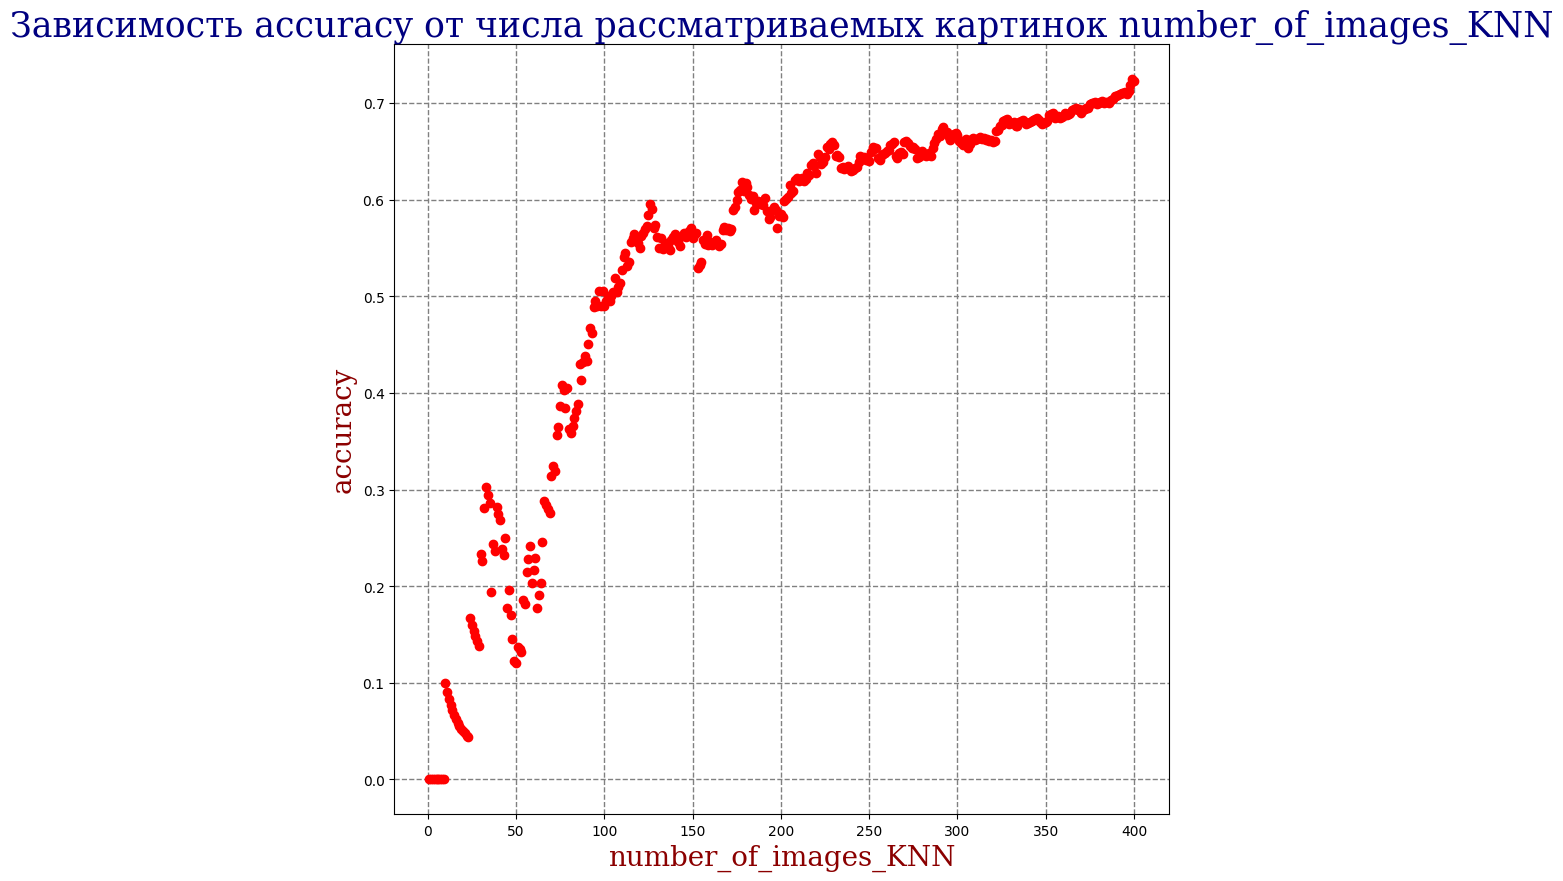

In [12]:
# accuracies = np.zeros((NUMBER_OF_IMAGES_KNN))
plt.figure(figsize = (10, 10))
for number_of_images_KNN in range(1, NUMBER_OF_IMAGES_KNN + 1, STEP):
    my_knn.fit(X_train[ : number_of_images_KNN], X_test[ : number_of_images_KNN], y_train[ : number_of_images_KNN])
    predicted_classes = [my_knn.predict(x_test).item() for x_test in X_test[ : number_of_images_KNN]]
    accuracy = sklearn.metrics.accuracy_score(y_test[ : number_of_images_KNN], predicted_classes)
    # accuracies[number_of_images_KN] = accuracy

    plt.plot(number_of_images_KNN, accuracy, marker = "o", color = "red")
plt.xlabel("number_of_images_KNN", fontdict = font1)
plt.ylabel("accuracy", fontdict = font1)
plt.title("Зависимость accuracy от числа рассматриваемых картинок number_of_images_KNN", fontdict = font2)
plt.grid(color = "gray", linestyle = "--", linewidth = 1.0)
plt.show()

In [38]:
my_pca = my_PCA(DIMENSIONS)
X_train_pca = my_pca.fit_transform(X_train[ : NUMBER_OF_IMAGES_KNN])
X_test_pca = my_pca.fit_transform(X_test[ : NUMBER_OF_IMAGES_KNN])

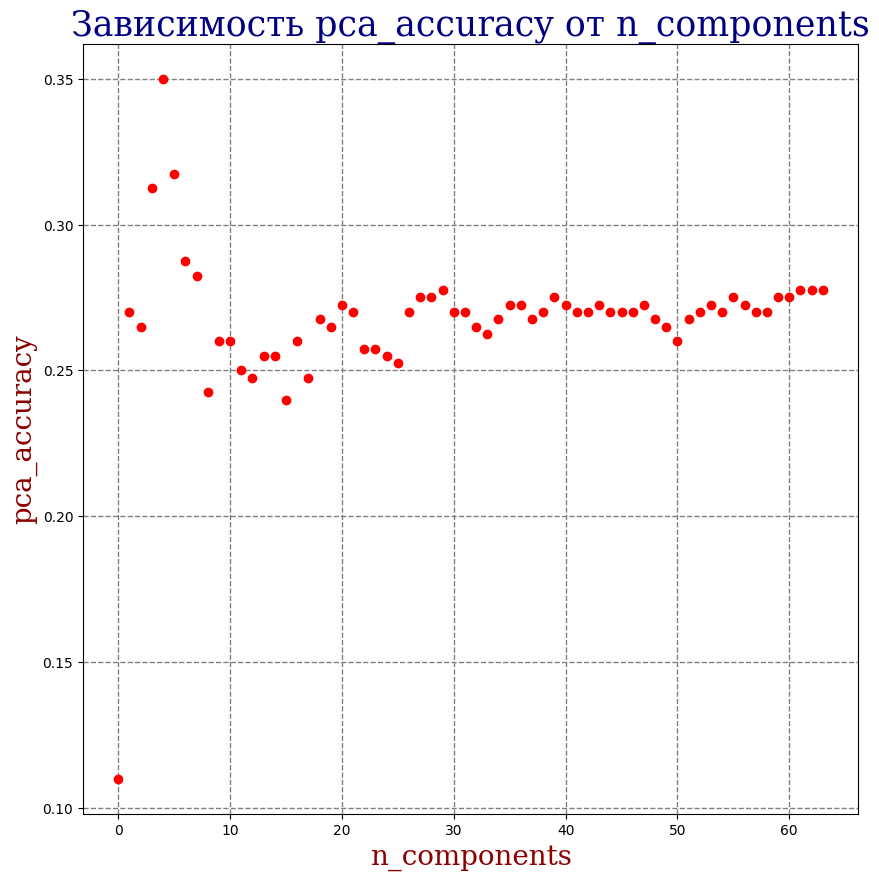

In [14]:
# pca_accuracies = np.zeros((DIMENSIONS))
plt.figure(figsize = (10, 10))
for n_components in range(0, DIMENSIONS, STEP):
    my_knn.fit(X_train_pca[ : NUMBER_OF_IMAGES_KNN, : n_components], X_test[ : NUMBER_OF_IMAGES_KNN, : n_components], y_train[ : NUMBER_OF_IMAGES_KNN])
    pca_predicted_classes = [my_knn.predict(x_test).item() for x_test in X_test_pca[ : NUMBER_OF_IMAGES_KNN, : n_components]]
    pca_accuracy = sklearn.metrics.accuracy_score(y_test[ : NUMBER_OF_IMAGES_KNN], pca_predicted_classes)
    # pca_accuracies[n_components] = pca_accuracy

    plt.plot(n_components, pca_accuracy, marker = "o", color = "red")
plt.xlabel("n_components", fontdict = font1)
plt.ylabel("pca_accuracy", fontdict = font1)
plt.title("Зависимость pca_accuracy от n_components", fontdict = font2)
plt.grid(color = "gray", linestyle = "--", linewidth = 1.0)
plt.show()

0.1275
0.1575
0.1775
0.1725
0.1725
0.175
0.165
0.1725
0.1675
0.17
0.175
0.1725
0.175
0.175
0.1725
0.1625
0.16
0.1625
0.16
0.165
0.1675
0.165
0.165
0.1675
0.165
0.17
0.1725
0.1725
0.175
0.1775


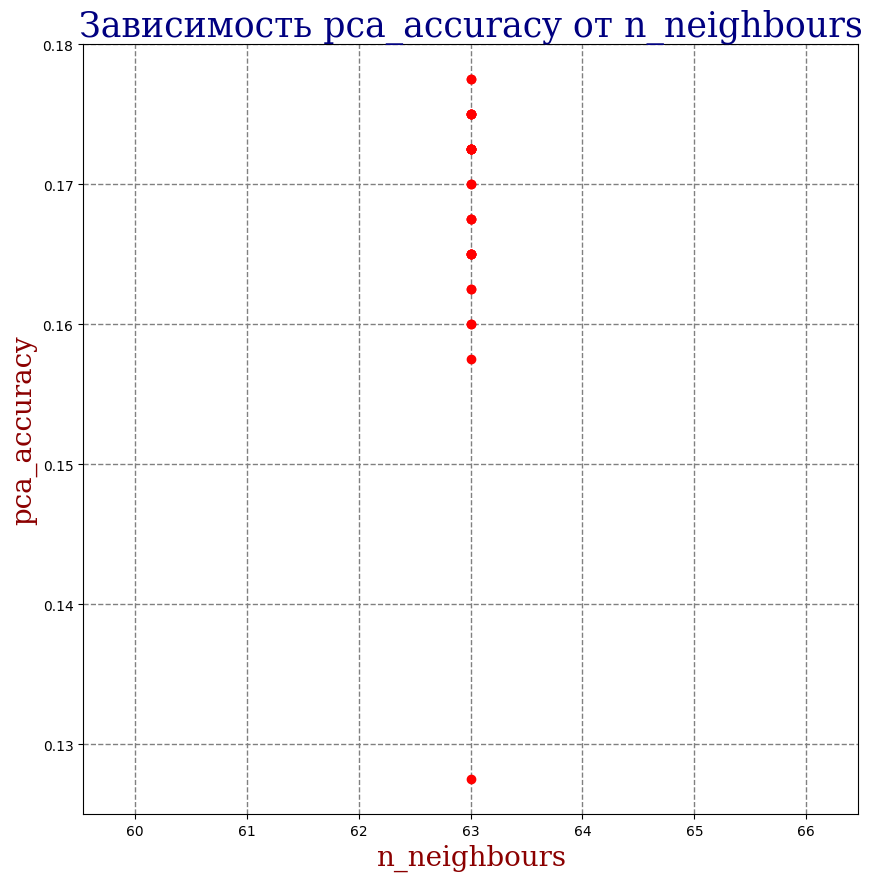

In [44]:
# pca_accuracies = np.zeros((DIMENSIONS))
my_knn.fit(X_train_pca[ : NUMBER_OF_IMAGES_KNN], X_test[ : NUMBER_OF_IMAGES_KNN], y_train[ : NUMBER_OF_IMAGES_KNN])
plt.figure(figsize = (10, 10))
for neighbours in range(1, NEIGHBOURS + 1, STEP):
    my_knn.set_number_of_neighbours(neighbours)
    # train_images = train[0].reshape(train[0].shape[0], -1).astype("float32")
    # train_classes = train[1].reshape(train[1].shape[0]).astype("uint8")
    # test_images = test[0].reshape(test[1].shape[0], -1).astype("float32")
    # X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(train_images, train_classes)

    # my_knn_temp.fit(X_train[ : NUMBER_OF_IMAGES_KNN, : n_components], X_test[ : NUMBER_OF_IMAGES_KNN, : n_components], y_train[ : NUMBER_OF_IMAGES_KNN])
    pca_predicted_classes = [my_knn.predict(x_test).item() for x_test in X_test_pca[ : NUMBER_OF_IMAGES_KNN]]
    pca_accuracy = sklearn.metrics.accuracy_score(y_test[ : NUMBER_OF_IMAGES_KNN], pca_predicted_classes)
    print(pca_accuracy)
    # pca_accuracies[n_components] = pca_accuracy

    plt.plot(n_components, pca_accuracy, marker = "o", color = "red")
plt.xlabel("n_neighbours", fontdict = font1)
plt.ylabel("pca_accuracy", fontdict = font1)
plt.title("Зависимость pca_accuracy от n_neighbours", fontdict = font2)
plt.grid(color = "gray", linestyle = "--", linewidth = 1.0)
plt.show()